In [9]:
import numpy as np
import cv2
from skimage.util import img_as_float
import tensorflow as tf
import matplotlib.pyplot as plt
import time
!pip install ffmpeg
import ffmpeg

In [10]:
from google.colab import drive
drive.mount('rppg')

Drive already mounted at rppg; to attempt to forcibly remount, call drive.mount("rppg", force_remount=True).


In [11]:
def DeepPhysPreprocessing(videoFilePath, dim):

    # load parameters
    start_time = time.time()
    dataURL = videoFilePath

    L = dim # 36
    t = []
    i = 1

    vidObj = cv2.VideoCapture(dataURL);   
    totalFrames = int(vidObj.get(cv2.CAP_PROP_FRAME_COUNT)) # get total frame size
    Xsub = np.zeros((totalFrames + 1, L, L, 3), dtype = np.float32)
    height = vidObj.get(cv2.CAP_PROP_FRAME_HEIGHT)
    width = vidObj.get(cv2.CAP_PROP_FRAME_WIDTH)

    print("height", height)
    print("width", width)
    
    success, img = vidObj.read()
    dims = img.shape

    while success:
      t.append(vidObj.get(cv2.CAP_PROP_POS_MSEC))# current timestamp in milisecond 
      time_cur = time.time()
      vidLxL = cv2.resize(img_as_float(img[:, int(width/2) - int(height/2 + 1) : int(height/2) + int(width/2), :]), (L, L))
      vidLxL = cv2.rotate(vidLxL, cv2.ROTATE_90_CLOCKWISE) # rotate 90 degree
      vidLxL[vidLxL > 1] = 1
      vidLxL[vidLxL < (1/255)] = 1/255
      Xsub[i, :, :, :] = vidLxL
      success, img = vidObj.read() # read the next one
      i = i + 1
    
    time_cur = time.time()
    dXsub = np.zeros((len(t) - 1, L, L, 3), dtype = np.float32)
    for j in range(1, len(t) - 1):
      dXsub[j, :, :, :] = (Xsub[j+1, :, :, :] - Xsub[j, :, :, :]) / (Xsub[j+1, :, :, :] + Xsub[j, :, :, :])
    dXsub = dXsub / np.std(dXsub, ddof=1)
    Xsub = Xsub - Xsub.mean(axis = 0)
    Xsub = Xsub  / np.std(Xsub, ddof=1)

    Xsub = Xsub[1:totalFrames, :, :, :]
    plt.imshow(dXsub[1, :, :, :]) # Plot an example of data after preprocess
    dXsub = np.concatenate((dXsub, Xsub), axis = 3);
    print(time.time() - start_time)
    print(dXsub.shape)
    return dXsub

height 1080.0
width 1920.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3.594715118408203
(148, 36, 36, 6)


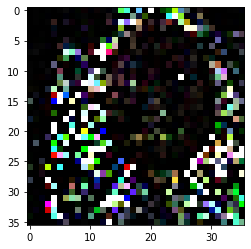

In [12]:
test = DeepPhysPreprocessing('rppg/My Drive/rppg/sample_video.mp4', 36)